In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

from utils import load_data
from normalization_helpers import tokenize_and_normalize


# Text preprocessing
Load data for each autor and preprocess it.

In [23]:
folder_paths = ['mickiewicz', 'slowacki', 'sienkiewicz', "reymont", "bronte"]

input_dim = 1000
hidden_dim = 512
output_size = len(folder_paths)


In [24]:
label_to_author = [(i, label) for i, label in enumerate(folder_paths)]
path_to_label = [(label, i) for i, label in enumerate(folder_paths)]
label_to_author = dict(label_to_author)
path_to_label = dict(path_to_label)
print(label_to_author)
print(path_to_label)

data_to_train = []
for folder_path in folder_paths:
    print()
    print(f"Loading data from {folder_path}")

    data = " ".join(load_data(folder_path))
    print(f"{folder_path} has {len(data)} characters")
    data_to_train.append((path_to_label[folder_path], data))


{0: 'mickiewicz', 1: 'slowacki', 2: 'sienkiewicz', 3: 'reymont', 4: 'bronte'}
{'mickiewicz': 0, 'slowacki': 1, 'sienkiewicz': 2, 'reymont': 3, 'bronte': 4}

Loading data from mickiewicz
mickiewicz/dziady.txt
mickiewicz/pan_tadeusz.txt
mickiewicz has 466638 characters

Loading data from slowacki
slowacki/kordian.txt
slowacki/balladyna.txt
slowacki has 302772 characters

Loading data from sienkiewicz
sienkiewicz/na_marne.txt
sienkiewicz/quo_vadis.txt
sienkiewicz/latarnik.txt
sienkiewicz has 373579 characters

Loading data from reymont
reymont/chłopi.txt
reymont has 408477 characters

Loading data from bronte
bronte/jane_eyre_fragment.txt
bronte has 112892 characters


## Text tokenization and normalization

The text is tokenized and normalized using the following steps:

```python
    words = remove_non_ascii(words)
    words = replace_numbers(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
```

Text is tokenized using the `nltk` library for polish language. Than the text is normalized by removing non-ascii characters, converting to lowercase, removing punctuation, replacing numbers with the word and removing polish stopwords.

In [25]:
preprocessed_data = []
for data in data_to_train:
    print(label_to_author[data[0]], len(data[1]))
    preprocessed = tokenize_and_normalize(data[1])
    print(label_to_author[data[0]], len(preprocessed))
    preprocessed_data.append((data[0], preprocessed))


mickiewicz 466638
['adam mickiewicz  dziady', 'poema dziady czesc ii   dziady', 'jest to nazwisko uroczystosci obchodzonej dotad miedzy pospolstwem w wielu powiatach litwy prus i kurlandii na pamiatke dziadow czyli w ogolnosci zmarych przodkow', 'uroczystosc ta poczatkiem swoim zasiega czasow poganskich i zwaa sie niegdys uczta koza na ktorej przewodniczy kozlarz huslar guslarz razem kapan i poeta geslarz', 'w terazniejszych czasach poniewaz swiate duchowienstwo i wasciciele usiowali wykorzenic zwyczaj poaczony z zabobonnymi praktykami i zbytkiem czestokroc nagannym pospolstwo wiec swieci dziady tajemnie w kaplicach lub pustych domach niedaleko cmentarza', 'zastawia sie tam pospolicie uczta z rozmaitego jada trunkow owocow i wywouja sie dusze nieboszczykow', 'godna uwagi iz zwyczaj czestowania zmarych zdaje sie byc wspolny wszystkim ludom poganskim w dawnej grecji za czasow homerycznych w skandynawii na wschodzie i dotad po wyspach nowego swiata', 'dziady nasze maja to szczegolnie iz o

### Creating pandas dataframes with labeled data

In [26]:

training_dataframes = []
for data in preprocessed_data:
    dictionary = {
        "text" : data[1],
        "label": np.full(len(data[1]), data[0], dtype=np.int16)
    }
    training_dataframes.append(pd.DataFrame.from_dict(dictionary))


for dataframe in training_dataframes:
    display(dataframe.head())


,text,label
0,adam mickiewicz dziady,0
1,poema dziady czesc ii dziady,0
2,jest to nazwisko uroczystosci obchodzonej dota...,0
3,uroczystosc ta poczatkiem swoim zasiega czasow...,0
4,w terazniejszych czasach poniewaz swiate ducho...,0


,text,label
0,juliusz sowacki kordian czesc pierwsza trylog...,1
1,tak egipcjanin w liscie z aloesu obwija zwiede...,1
2,juliusza sowackiego lambro przygotowanie ...,1
3,ciemnosc przerwana byskawicami,1
4,czarownica czesze wosy i spiewa czarowni...,1


,text,label
0,henryk sienkiewicz na marne i otoz i kijow,2
1,tak mowi do siebie mody czowiek nazwiskiem joz...,2
2,serce zadrgao mu radosnie by mody dar sie do z...,2
3,buda zydowska toczya sie z wolna podskakujac n...,2
4,szwarcowi sprzykrzyo sie siedziec w niej pod p...,2


,text,label
0,wadysaw stanisaw reymont chopi czesc pierwsza...,3
1,na wieki wiekow moja agato a dokad to wedruje...,3
2,we swiat do ludzi dobrodzieju kochany w tyli...,3
3,ksiadz spojrza bezwiednie w te dal i rycho prz...,3
4,a moze to ino niezgoda moze nie zaraz odrzeka...,3


,text,label
0,charlotte bronte dziwne losy jane eyre tum,4
1,teresa swiderska isbn 9788328870925 rozdz...,4
2,rano co prawda snulismy sie z godzine po bezli...,4
3,rada byam z tego nigdy nie lubiam dugich space...,4
4,eliza john i georgiana skupili sie teraz dokoa...,4


Creating one randomly shuffeled dataframe with all the data.

In [27]:
df = pd.concat(training_dataframes, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,niech zdycha a nie przeszkadza ludziom jesc,3
1,sam nie wie i ten gniew wielki jak sie zaja w ...,0
2,z tiary na pastora rusza przeklete zwierze pta...,1
3,dobrodziej powiedzia ze i w miescie nie spotka...,3
4,uwi kak siana i wyczysci jej bok zawalany,3


### Vectorizing text by using TfidfVectorizer

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=input_dim, min_df= 3, max_df=0.6)
X = vectorizer.fit_transform(df["text"]).toarray()
X[2][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [29]:
y = df["label"].values
y_0 =df.where(df["label"] == 0).dropna().values
y_1 =df.where(df["label"] == 1).dropna().values
y
len(y), len(y_0), len(y_1)

(16528, 3865, 3640)

# Creating train and test splits

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape


((9916, 1000), (3306, 1000), (3306, 1000))

In [31]:
def one_hot_encode(y):
    """
     Function to one hot encode the labels
    """
    y_encoded = np.zeros((len(y), len(folder_paths)))
    for i, label in enumerate(y):
        y_encoded[i][label] = 1
    return y_encoded


In [32]:
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)
y_valid = one_hot_encode(y_valid)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()


In [33]:
X_train.shape, X_train.shape

(torch.Size([9916, 1000]), torch.Size([9916, 1000]))

In [34]:
y_train.shape, y_train[:10]

(torch.Size([9916, 5]),
 tensor([[1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.]]))

In [35]:
y_valid.shape, y_valid[:10]

(torch.Size([3306, 5]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 0.]]))

In [36]:
input_size = 1000
output_size = len(folder_paths) # number of authors (classes)
hidden_size = 512

batch_size = 62

In [37]:
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
valid_dataset = CustomDataset(X_valid, y_valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [38]:
from sklearn.metrics import roc_auc_score
from IPython import display as disp


def training_loop(model, train_dataloader, valid_dataloader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_data = []
    fig, ax = plt.subplots(ncols=2, figsize=(15, 3), layout="constrained")
    fig.suptitle(f"Training progress - {model.name.value}")
    dh = disp.display(fig, display_id=True)
    acc_valid = []
    nr_of_epochs = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        train_loss /= len(train_dataloader)
        loss_data.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, labels = torch.max(labels, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = 100 * valid_correct / valid_total
        valid_loss /= len(valid_dataloader)

        acc_valid.append(valid_accuracy)

        nr_of_epochs.append(epoch)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.2f}%")
        print()
        ax[0].clear()
        # ax.figure(figsize=(8, 4))
        ax[0].plot(nr_of_epochs,loss_data, label="Training loss")
        ax[0].legend()

        ax[1].clear()
        ax[1].plot(nr_of_epochs,acc_valid, label="Valid accuracy")
        ax[1].legend()
        dh.update(fig)

    plt.savefig(f"results/{model.name.value.lower()}/training_loss.png")
    model.eval()
    return model

# Models

In [39]:
from enum import Enum

class ModelType(Enum):
    LINEAR_MODEL = "LINEAR_MODEL"
    CONVOLUTIONAL_MODEL = "CONVOLUTIONAL_MODEL"
    LOGISTIC_REGRESSION = "LOGISTIC_REGRESSION"
    RANDOM_FOREST = "RANDOM_FOREST"

In [40]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.name = ModelType.LINEAR_MODEL
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

    def train_model(self, train_loader, valid_loader, epochs, lr):
        training_loop(self, train_loader, valid_loader, epochs, lr)


class ConvolutionalNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(ConvolutionalNet, self).__init__()
        self.name = ModelType.CONVOLUTIONAL_MODEL
        self.conv1 = nn.Conv1d(input_dim, hidden_size, 3, padding=1)
        self.batchNorm1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, 3, padding=1)
        self.batchNorm2 = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, output_dim)
        self.softMax = nn.Softmax()

    def forward(self, X):
        X = X.squeeze(0)
        X = X.T
        out = self.conv1(X)
        out = out.T
        out = self.batchNorm1(out)
        out = out.T
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.T
        out = self.batchNorm2(out)
        out = out.T
        out = self.dropout(out)
        out = self.fc1(out.T)
        out = self.fc2(out)
        out = self.softMax(out)
        return out

    def train_model(self, train_loader, valid_loader, epochs, lr):
        training_loop(self, train_loader, valid_loader, epochs, lr)


from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import  RandomForestClassifier as RFC

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.name = ModelType.LOGISTIC_REGRESSION
        self.model = LR(solver="liblinear")

    def __call__(self, X):
        return torch.tensor(self.model.predict_proba(X))

    def forward(self, X):
        return self.model(X)

    def train_model(self, X_train, y_train):
        y = np.argmax(y_train, axis=1)
        self.model.fit(X_train, y)

class RandomForest(nn.Module):
    def __init__(self):
        super(RandomForest, self).__init__()
        self.name = ModelType.RANDOM_FOREST
        self.model = RFC(criterion = 'entropy', random_state = 42, n_estimators=500, max_depth=70)

    def __call__(self, X):
        return torch.tensor(self.model.predict_proba(X))

    def forward(self, X):
        return self.model(X)

    def train_model(self, X_train, y_train):
        y = np.argmax(y_train, axis=1)
        self.model.fit(X_train, y)


In [41]:
from sklearn.metrics import classification_report
import yaml

def save_results(model: ModelType, data, results_df):
    path_to_dir = f"results/{model.value.lower()}"
    if not os.path.exists(path_to_dir):
        os.makedirs(path_to_dir)

    with open(f"{path_to_dir}/results.yml", 'w') as file:
        yaml.dump(data, file)

    results_df.to_csv(f"{path_to_dir}/test_predictions.csv")


def test_model(model, X_test, y_test):
    with torch.no_grad():
        output = model(X_test)

        output = output.numpy()
        y_test = y_test.numpy()

        print("output: ", output[:3])

        predicted = np.argmax(output, axis=1)
        y_test = np.argmax(y_test, axis=1)

        print("test values: ", y_test[:10])
        print("predicted values: ",predicted[:10])

        correct_predictions_dict = {label: 0 for label in range(len(folder_paths))}
        total_preddictions_dict = {label: 0 for label in range(len(folder_paths))}


        for label, prediction in zip(y_test, predicted):
            if label == prediction:
                correct_predictions_dict[label] += 1
            total_preddictions_dict[label] += 1

        print(correct_predictions_dict.values())
        corectly_predicted_values = sum(correct_predictions_dict.values())

        for classname, correct_count in correct_predictions_dict.items():
            accuracy = 100 * float(correct_count) / total_preddictions_dict[classname]
            print(f'Accuracy for class: {classname} - {label_to_author[classname]} is {accuracy:.1f} %')

        sk_report = classification_report(
            digits=3,
            y_true=y_test,
            y_pred=predicted)
        print(sk_report)

        roc_auc = roc_auc_score(y_test, output, multi_class="ovo")

        print("Overall metrics:")
        print(f"Accuracy: {100 * corectly_predicted_values/len(y_test):.2f}%")
        print(f"Roc auc score: {roc_auc:.3f}")

        data_to_save = {
            "accuracy": 100 * corectly_predicted_values/len(y_test),
            "roc_auc": float(roc_auc),

        }
        results_df = pd.DataFrame(
            {
                "predictions": predicted,
                "y": y_test,
            }
        )
        save_results(model.name, data_to_save, results_df)


Training model ModelType.LOGISTIC_REGRESSION
output:  [[0.08605931 0.01835182 0.70990024 0.17510714 0.01058149]
 [0.21109607 0.28559385 0.26038054 0.17353506 0.06939448]
 [0.06160718 0.06176152 0.75959502 0.0907686  0.02626769]]
test values:  [2 1 2 0 1 0 4 1 4 1]
predicted values:  [2 1 2 2 1 0 2 1 3 1]
dict_values([487, 473, 615, 458, 77])
Accuracy for class: 0 - mickiewicz is 62.0 %
Accuracy for class: 1 - slowacki is 70.0 %
Accuracy for class: 2 - sienkiewicz is 67.1 %
Accuracy for class: 3 - reymont is 69.5 %
Accuracy for class: 4 - bronte is 28.5 %
              precision    recall  f1-score   support

           0      0.600     0.620     0.610       785
           1      0.599     0.700     0.645       676
           2      0.643     0.671     0.657       916
           3      0.715     0.695     0.705       659
           4      0.726     0.285     0.410       270

    accuracy                          0.638      3306
   macro avg      0.656     0.594     0.605      3306
weigh

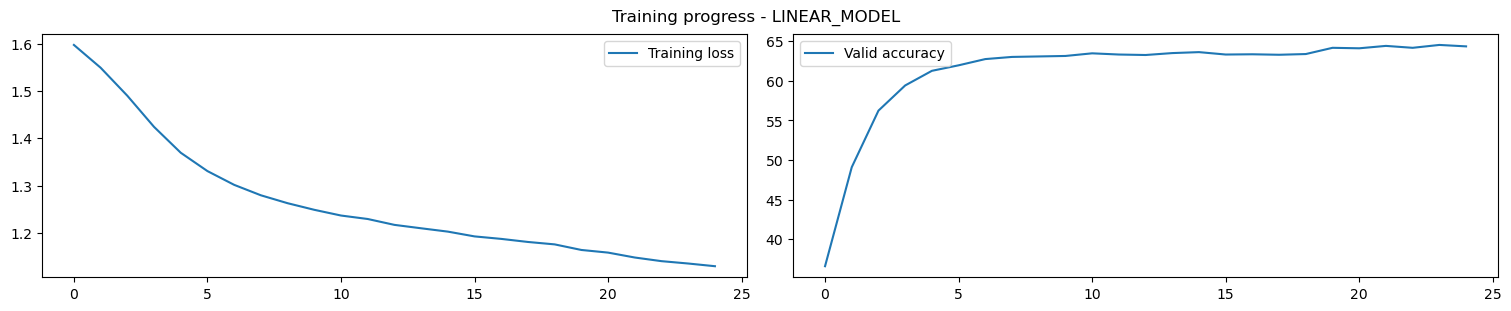

Epoch 1/25:
Train Loss: 1.5970 | Train Accuracy: 25.24%
Valid Loss: 1.5758 | Valid Accuracy: 36.60%

Epoch 2/25:
Train Loss: 1.5489 | Train Accuracy: 38.11%
Valid Loss: 1.5261 | Valid Accuracy: 49.09%

Epoch 3/25:
Train Loss: 1.4898 | Train Accuracy: 48.13%
Valid Loss: 1.4587 | Valid Accuracy: 56.23%

Epoch 4/25:
Train Loss: 1.4240 | Train Accuracy: 54.86%
Valid Loss: 1.3982 | Valid Accuracy: 59.41%

Epoch 5/25:
Train Loss: 1.3694 | Train Accuracy: 58.79%
Valid Loss: 1.3582 | Valid Accuracy: 61.25%

Epoch 6/25:
Train Loss: 1.3306 | Train Accuracy: 61.80%
Valid Loss: 1.3286 | Valid Accuracy: 61.95%

Epoch 7/25:
Train Loss: 1.3016 | Train Accuracy: 63.74%
Valid Loss: 1.3102 | Valid Accuracy: 62.73%

Epoch 8/25:
Train Loss: 1.2795 | Train Accuracy: 65.45%
Valid Loss: 1.2994 | Valid Accuracy: 63.01%

Epoch 9/25:
Train Loss: 1.2628 | Train Accuracy: 66.54%
Valid Loss: 1.2904 | Valid Accuracy: 63.07%

Epoch 10/25:
Train Loss: 1.2489 | Train Accuracy: 67.77%
Valid Loss: 1.2839 | Valid Accurac

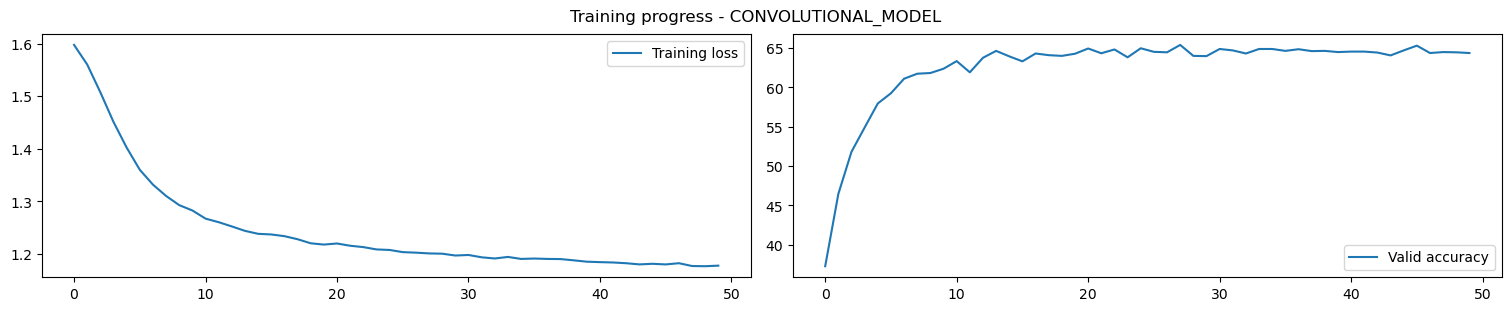

/Users/krystynawaniova/opt/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/50:
Train Loss: 1.5974 | Train Accuracy: 25.91%
Valid Loss: 1.5801 | Valid Accuracy: 37.27%



[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 2/50:
Train Loss: 1.5602 | Train Accuracy: 38.12%
Valid Loss: 1.5376 | Valid Accuracy: 46.46%

Epoch 3/50:
Train Loss: 1.5074 | Train Accuracy: 46.63%
Valid Loss: 1.4814 | Valid Accuracy: 51.81%

Epoch 4/50:
Train Loss: 1.4510 | Train Accuracy: 51.86%
Valid Loss: 1.4277 | Valid Accuracy: 54.90%

Epoch 5/50:
Train Loss: 1.4022 | Train Accuracy: 55.85%
Valid Loss: 1.3845 | Valid Accuracy: 57.96%

Epoch 6/50:
Train Loss: 1.3600 | Train Accuracy: 58.89%
Valid Loss: 1.3530 | Valid Accuracy: 59.26%

Epoch 7/50:
Train Loss: 1.3318 | Train Accuracy: 60.64%
Valid Loss: 1.3296 | Valid Accuracy: 61.10%

Epoch 8/50:
Train Loss: 1.3103 | Train Accuracy: 61.75%
Valid Loss: 1.3143 | Valid Accuracy: 61.74%

Epoch 9/50:
Train Loss: 1.2928 | Train Accuracy: 63.47%
Valid Loss: 1.3039 | Valid Accuracy: 61.83%

Epoch 10/50:
Train Loss: 1.2826 | Train Accuracy: 63.95%
Valid Loss: 1.2941 | Valid Accuracy: 62.37%

Epoch 11/50:
Train Loss: 1.2671 | Train Accuracy: 65.38%
Valid Loss: 1.2830 | Valid Accura

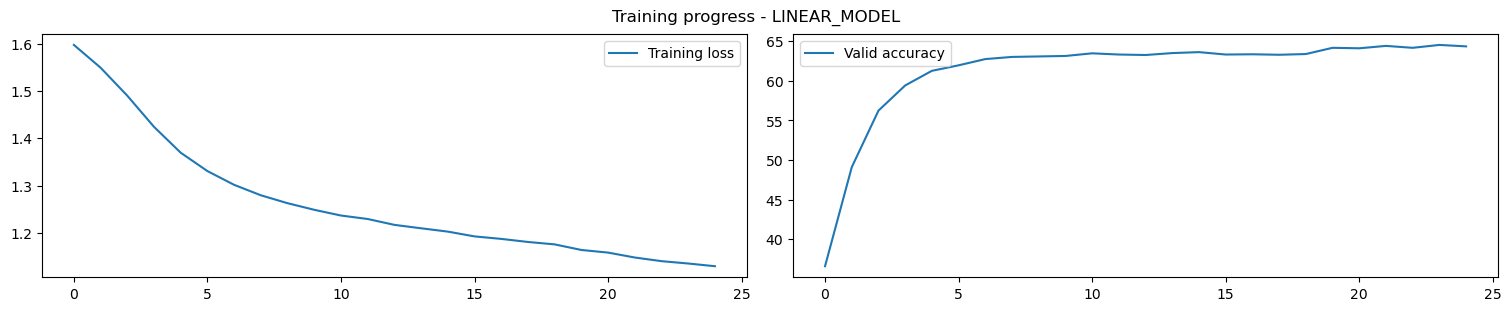

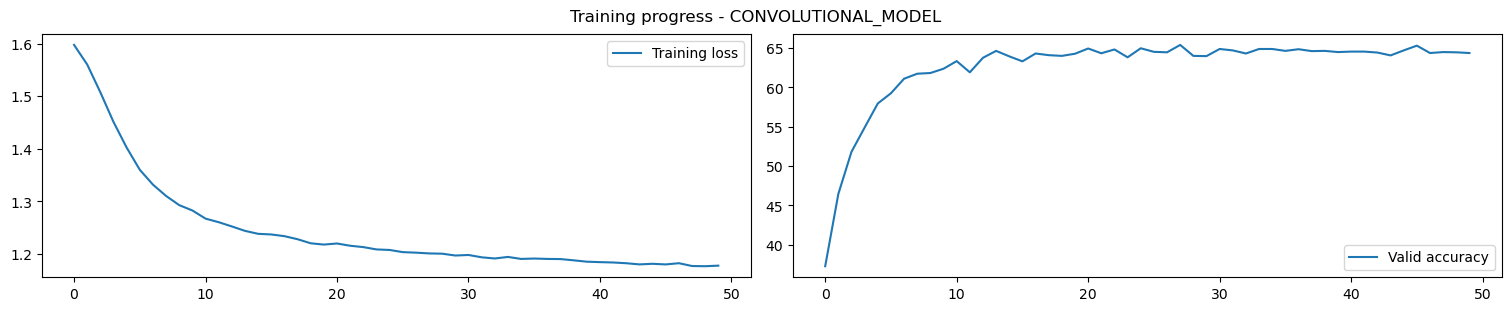

In [42]:
models = [LogisticRegression(), RandomForest()]

for model in models:
    print(f"Training model {model.name}")
    model.train_model(X_train, y_train)
    test_model(model, X_test, y_test)


epochs = 25
learning_rate = 0.00003
model = Net(input_dim, 512, output_size)
print(f"Training model {model.name}")

model.train_model(train_dataloader, valid_dataloader, epochs, learning_rate)

epochs = 50
learning_rate = 0.00001

model = ConvolutionalNet(input_dim, hidden_dim, output_size)
print(f"Training model {model.name}")

train_dataset_conv = CustomDataset(X_train, y_train)
valid_dataset_conv = CustomDataset(X_valid, y_valid)
train_loader = DataLoader(train_dataset_conv, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_conv, batch_size=batch_size, shuffle=True)

model.train_model(train_loader, valid_loader, epochs, learning_rate)


Results for model: logistic_regression
{'accuracy': 63.82335148215366, 'roc_auc': 0.8755179923243281}
no
Results for model: convolutional_model
{'accuracy': 63.7748624629708, 'roc_auc': 0.8166235319956812}


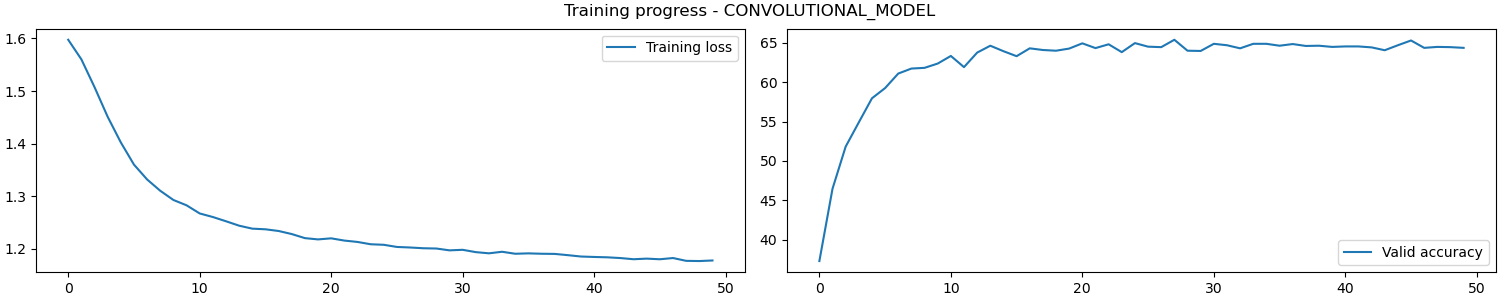

Results for model: random_forest
{'accuracy': 56.17059891107078, 'roc_auc': 0.8336397861142233}
no
Results for model: linear_model
{'accuracy': 69.69953449005502, 'roc_auc': 0.865577024633478}


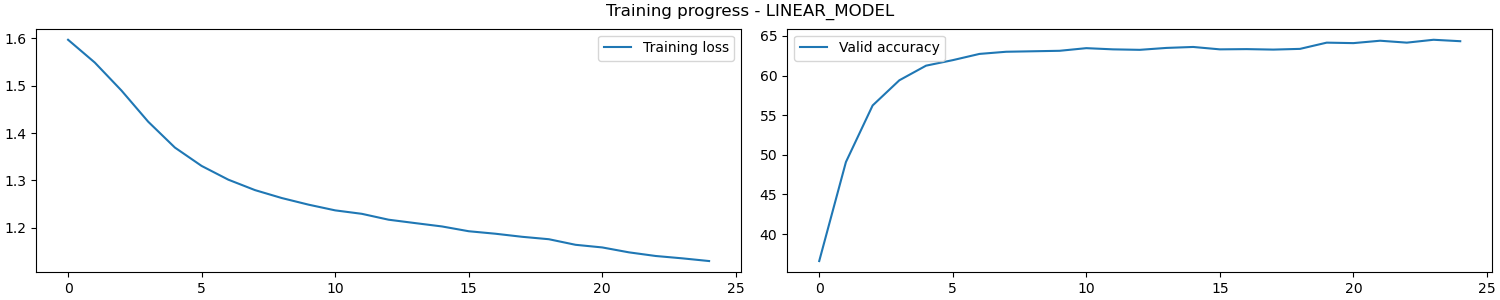

,model,accuracy,roc_auc
3,linear_model,69.699534,0.865577
0,logistic_regression,63.823351,0.875518
1,convolutional_model,63.774862,0.816624
2,random_forest,56.170599,0.833640


In [43]:
import os
from PIL import Image


folder_path = 'results'  # Specify the path to the "results" directory

accuracy = []
roc_auc = []
models = []
for folder_name in os.listdir(folder_path):
    folder_dir = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder_dir):  # Check if the item is a directory
        print(f"Results for model: {folder_name}")
        with open(f"{folder_dir}/results.yml", 'r') as file:
            data = yaml.load(file, Loader=yaml.FullLoader)
            print(data)
            models.append(folder_name)
            accuracy.append(data['accuracy'])
            roc_auc.append(data['roc_auc'])

            try:
                image = Image.open(f"{folder_dir}/training_loss.png")
                display(image)
            except FileNotFoundError:
                print("no")

df = pd.DataFrame(
    {
        "model": models,
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }
)

df.sort_values(by="accuracy", ascending=False)
